In [ ]:
import cv2
import torch
from ultralytics import YOLO
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os
from torch import nn, optim
from torchvision import models

# Load the YOLOv8 model for human detection
yolo_model = YOLO("yolov8n.pt")  # Load the YOLOv8 model (small version)

# Dataset class to load images and labels from folders
class PETS2009Dataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform
        
        # Load image paths
        self.image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith('.jpg') or img.endswith('.png')]
        
        # Load corresponding labels for each image
        self.labels = []
        for img_path in self.image_paths:
            label_file = os.path.join(label_folder, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
            if os.path.exists(label_file):
                label = self.load_label(label_file)
                self.labels.append(label)
            else:
                # If label file is missing, handle as needed (e.g., skipping or using default label)
                self.labels.append([0] * 17)  # Example: assume 17 keypoints with zeros
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float32)

    def load_label(self, label_file):
        """
        Function to load labels from a text file. Assuming each label is a series of 
        space-separated floats (x, y coordinates of key points or similar).
        """
        with open(label_file, 'r') as file:
            label = [float(val) for val in file.read().split()]
        return label

# Data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Folder paths
image_folder = "Time_12-34"  # Folder containing images
label_folder = "labels_folder_time"  # Folder containing labels (with .txt files)

# Initialize the dataset and dataloader
dataset = PETS2009Dataset(image_folder, label_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Load the pre-trained ResNet-50 model for pose detection
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 17)  # Adjust for the number of pose keypoints (17 in this case)

# Loss function and optimizer
criterion = nn.MSELoss()  # Using MSE for pose estimation tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to perform human detection with YOLO
def detect_human_with_yolo(image):
    results = yolo_model(image)  # Detect using YOLOv8
    # The result will have a 'boxes' attribute containing the bounding boxes for detected objects
    # Access the boxes, labels, and scores directly from results
    boxes = results[0].boxes.xyxy  # Get bounding box coordinates (x1, y1, x2, y2)
    scores = results[0].boxes.conf  # Get the confidence scores for the predictions
    labels = results[0].boxes.cls  # Get the predicted class labels
    
    # Filter the boxes for humans (class 0 is usually for humans in YOLO)
    human_boxes = []
    for box, score, label in zip(boxes, scores, labels):
        if label == 0:  # Class 0 is usually for humans in YOLO models
            if score > 0.5:  # Optionally, filter based on confidence score
                human_boxes.append(box)  # Append the bounding box of the human

    return human_boxes

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f"start Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()

        # Apply YOLO human detection on the input image
        for img in inputs:
            img = transforms.ToPILImage()(img)  # Convert Tensor to PIL image
            human_boxes = detect_human_with_yolo(img)  # Get detected human boxes

            # If human detected, crop the image and feed it into the model
            for box in human_boxes:
                x1, y1, x2, y2 = map(int, box)  # Get coordinates of the bounding box
                cropped_img = img.crop((x1, y1, x2, y2))  # Crop the human from the image

                # Transform the cropped image for model input
                cropped_img = transform(cropped_img).unsqueeze(0)  # Add batch dimension
                
                # Run the cropped image through the model for pose detection
                outputs = model(cropped_img)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

# Save the trained model
torch.save(model.state_dict(), "resnet50_pose_detection_with_yolo.pth")


c:\Users\Administrator\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Administrator\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



0: 640x640 (no detections), 54.3ms
Speed: 5.6ms preprocess, 54.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 54.1ms
Speed: 3.7ms preprocess, 54.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 101.1ms
Speed: 3.0ms preprocess, 101.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 53.3ms
Speed: 3.3ms preprocess, 53.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 52.6ms
Speed: 2.8ms preprocess, 52.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 50.9ms
Speed: 3.0ms preprocess, 50.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 49.9ms
Speed: 3.2ms preprocess, 49.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 47.9ms
Speed: 3.3ms preprocess, 47.9ms

c:\Users\Administrator\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 17])) that is different to the input size (torch.Size([1, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0: 640x640 (no detections), 52.3ms
Speed: 3.5ms preprocess, 52.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 79.2ms
Speed: 3.3ms preprocess, 79.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 traffic light, 48.1ms
Speed: 14.0ms preprocess, 48.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 49.5ms
Speed: 3.5ms preprocess, 49.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 49.8ms
Speed: 3.1ms preprocess, 49.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 51.5ms
Speed: 3.2ms preprocess, 51.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 49.3ms
Speed: 3.6ms preprocess, 49.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 52.4ms
Speed: 3.1ms preprocess, 52.4ms inference, 

c:\Users\Administrator\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([27, 17])) that is different to the input size (torch.Size([1, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



0: 640x640 (no detections), 119.3ms
Speed: 4.6ms preprocess, 119.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 122.5ms
Speed: 7.5ms preprocess, 122.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 159.7ms
Speed: 4.1ms preprocess, 159.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 103.1ms
Speed: 7.7ms preprocess, 103.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 125.1ms
Speed: 8.2ms preprocess, 125.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 201.0ms
Speed: 9.4ms preprocess, 201.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cake, 105.8ms
Speed: 7.6ms preprocess, 105.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)
Epoch 5/10, Loss: 0.0048104625940322875

0: 640x640 (no detectio

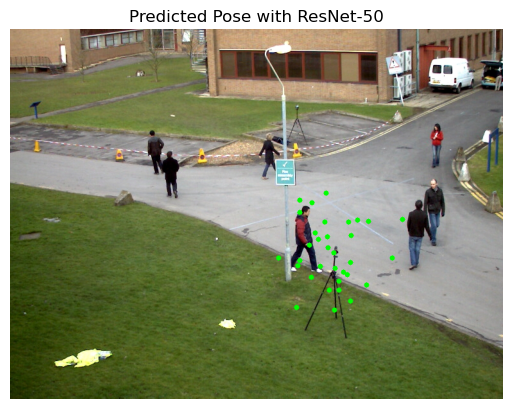

In [ ]:
# ========================================
# STEP 4: Use Trained Model for Selfie Pose Prediction + MediaPipe Segmentation
# ========================================

from torchvision.transforms.functional import to_pil_image

# Load a selfie image
selfie_image_path = "frame_0794.jpg"  # Replace with your selfie image path
selfie_image = Image.open(selfie_image_path).convert('RGB')
input_tensor = transform(selfie_image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    predicted_keypoints = model(input_tensor).cpu().numpy().reshape(33, 3)

# Visualize keypoints on image
import matplotlib.pyplot as plt
import numpy as np

image_np = np.array(selfie_image)
for x, y, z in predicted_keypoints:
    cx, cy = int(x * image_np.shape[1]), int(y * image_np.shape[0])
    cv2.circle(image_np, (cx, cy), 4, (0, 255, 0), -1)

plt.imshow(image_np)
plt.title("Predicted Pose with ResNet-50")
plt.axis('off')
plt.show()


In [ ]:
# Optional: Segment selfie using MediaPipe
mp_selfie_segmentation = mp.solutions.selfie_segmentation
with mp_selfie_segmentation.SelfieSegmentation(model_selection=1) as selfie_seg:
    selfie_rgb = np.array(selfie_image)
    selfie_seg_result = selfie_seg.process(selfie_rgb)

    mask = selfie_seg_result.segmentation_mask > 0.5
    segmented = np.where(mask[..., None], selfie_rgb, 255)

    plt.imshow(segmented)
    plt.title("MediaPipe Selfie Segmentation")
    plt.axis('off')
    plt.show()